In [2]:
!pip install keras-segmentation

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 28.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.3/753.3 kB 37.8 MB/s eta 0:00:00
  Created wheel for keras-segmentation: filename=keras_segmentation-0.3.0-py3-none-any.whl size=29071 sha256=c6dc84b6060adbb3cf3c263e2eedb45e60b8f8978dcf1557a31634b561adecf8
  Stored in directory: /root/.cache/pip/wheels/4f/24/79/577919a36a6df6a8116573e31967b7527b491705f8349dbd0c
Successfully built keras-segmentation
  Attempting uninstall: imageio
    Found existing installation: imageio 2.25.0
    Uninstalling imageio-2.25.0:
      Successfully uninstalled imageio-2.25.0
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.4.0
    Uninstalling imgaug-0.4.0:
      Successfully uninstalled imgaug-0.4.0


In [4]:
from keras_segmentation.models.pspnet import resnet50_pspnet
import tensorflow as tf
cce=tf.keras.losses.CategoricalCrossentropy()


**We are going to evaluate performance based on how the model predicts the three following images**

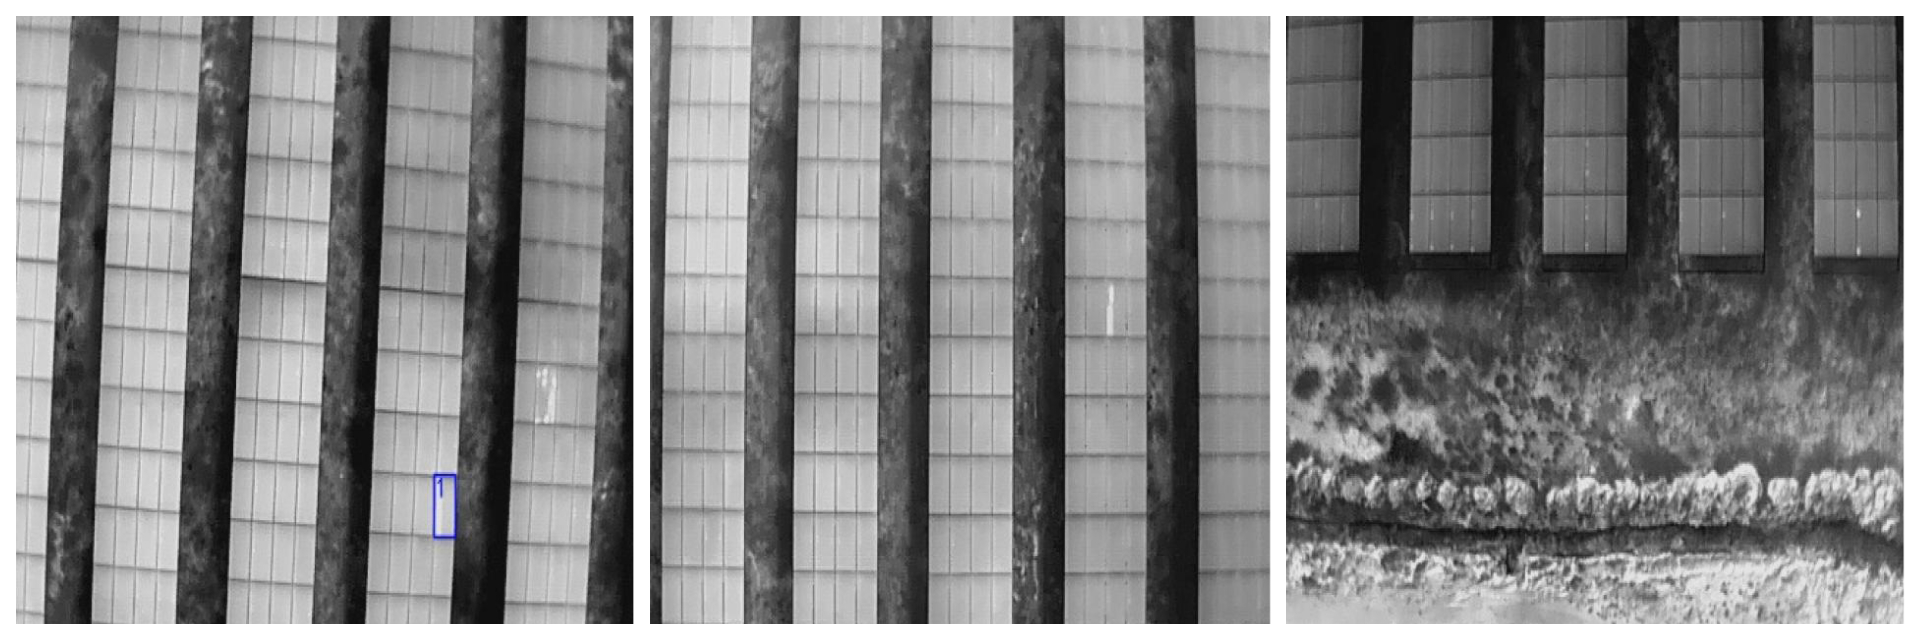

### Model 1
**Using pretrained pspnet model with default loss ( cce) and using dataset of type 2**

In [51]:
model1 = resnet50_pspnet(n_classes=5 ,  input_height=384, input_width=576)
model1.train( 
    train_images =  "/kaggle/input/defects-in-solar-panels/train",
    train_annotations = "/kaggle/input/defects-in-solar-panels/train_annots",
    val_images="/kaggle/input/defects-in-solar-panels/valid",
    val_annotations="/kaggle/input/defects-in-solar-panels/valid_annots",
    checkpoints_path = "/kaggle/working/" , epochs=5
)
out1_0 = model1.predict_segmentation(
    inp="/kaggle/input/defects-in-solar-panels/valid/img2.png",
    out_fname="default-img2-set2.png"
)
out1_1 = model1.predict_segmentation(
    inp="/kaggle/input/defects-in-solar-panels/valid/img13.png",
    out_fname="default-img13-set2.png"
)
out1_3 = model1.predict_segmentation(
    inp="/kaggle/input/defects-in-solar-panels/valid/img7.png",
    out_fname="default-img7-set2.png"
)


Verifying training dataset


100%|██████████| 249/249 [00:02<00:00, 103.86it/s]


Dataset verified! 
Epoch 1/5
512/512 [==============================] - 98s 131ms/step - loss: 0.7197 - accuracy: 0.8419
Epoch 2/5
512/512 [==============================] - 66s 129ms/step - loss: 0.2607 - accuracy: 0.9677
Epoch 3/5
512/512 [==============================] - 66s 129ms/step - loss: 0.1869 - accuracy: 0.9684
Epoch 4/5
512/512 [==============================] - 67s 130ms/step - loss: 0.1723 - accuracy: 0.9684
Epoch 5/5
1/1 [==============================] - 0s 35ms/step


**Predicted images**

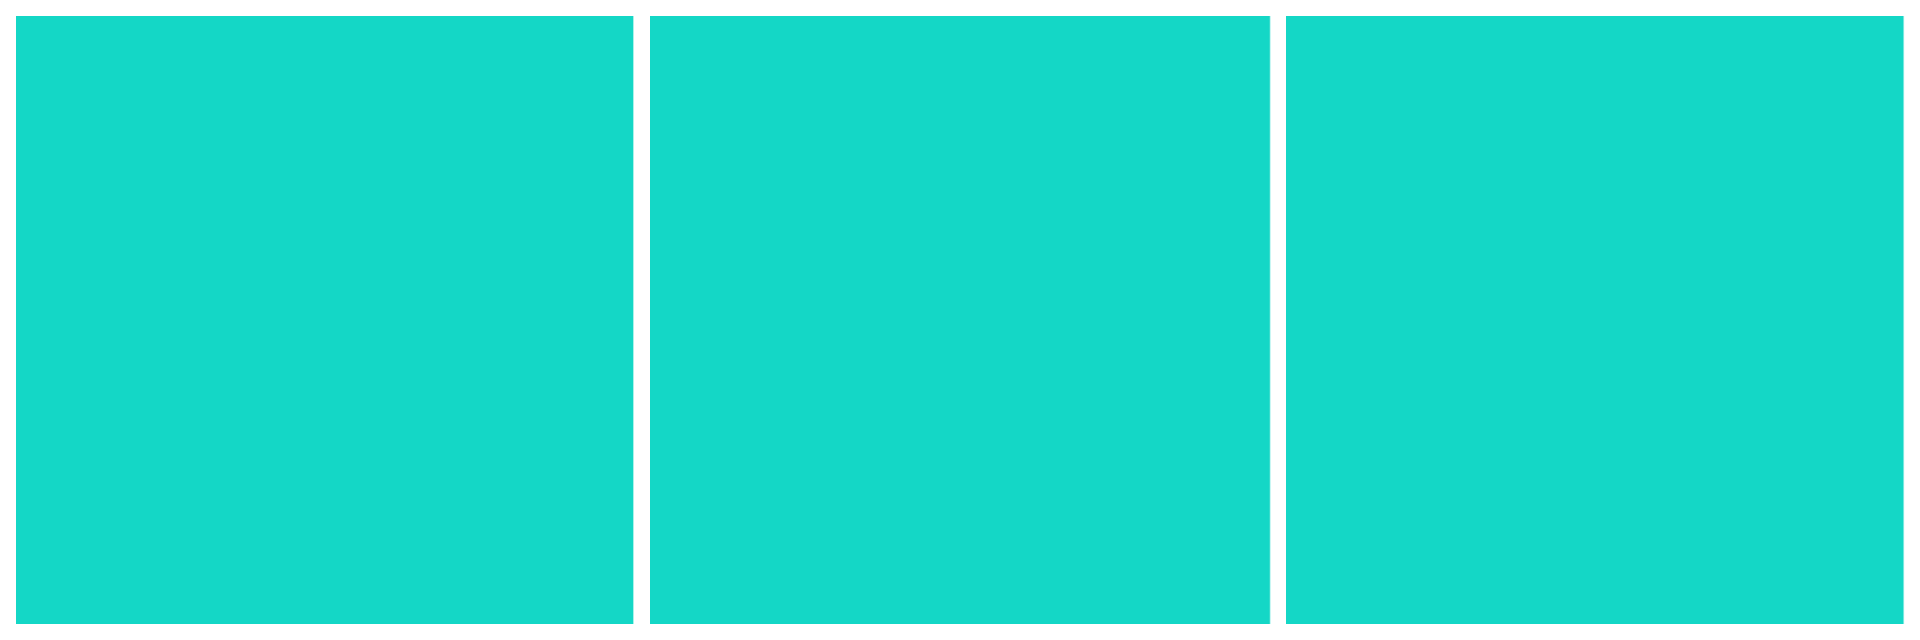

**Inference:**

1. Classifies every pixel as class 0 , due to class 0 being the most present. This reduces error but is also not the right intended way

**Proposed solution to the problem**

1. Use Categorical cross entropy with weights. assign very low weight ranging from 0 to 1e-5 for class 0 and give very high loss scalar for missclassifying other classes. we can then adjust after trial and error

### Model 2
**Using pretrained pspnet model with weighted categorical cross entropy and using dataset of type 2**

Part one: loss_weight=[0,1e5,1e5,1e5,1e5]

In [52]:
cce=tf.keras.losses.CategoricalCrossentropy()
model2 = resnet50_pspnet(n_classes=5 ,  input_height=384, input_width=576)
model2.compile(optimizer='adam', loss=cce,loss_weights=[0,1e5,1e5,1e5,1e5])

In [53]:
model2.train( 
    train_images =  "/kaggle/input/defects-in-solar-panels/train",
    train_annotations = "/kaggle/input/defects-in-solar-panels/train_annots",
    val_images="/kaggle/input/defects-in-solar-panels/valid",
    val_annotations="/kaggle/input/defects-in-solar-panels/valid_annots",
    checkpoints_path = "/kaggle/working/" , epochs=5
)

Verifying training dataset


100%|██████████| 249/249 [00:02<00:00, 108.84it/s]


Dataset verified! 
Epoch 1/5
512/512 [==============================] - 98s 130ms/step - loss: 1.1673 - accuracy: 0.5677
Epoch 2/5
512/512 [==============================] - 66s 129ms/step - loss: 0.3364 - accuracy: 0.9636
Epoch 3/5
512/512 [==============================] - 66s 129ms/step - loss: 0.2001 - accuracy: 0.9684
Epoch 4/5
512/512 [==============================] - 66s 129ms/step - loss: 0.1784 - accuracy: 0.9683
Epoch 5/5
512/512 [==============================] - 66s 129ms/step - loss: 0.1693 - accuracy: 0.9684


In [55]:
out2_0 = model2.predict_segmentation(
    inp="/kaggle/input/defects-in-solar-panels/valid/img2.png",
    out_fname="Wcce-img2-set2.png"
)
out2_1 = model2.predict_segmentation(
    inp="/kaggle/input/defects-in-solar-panels/valid/img13.png",
    out_fname="Wcce-img13-set2.png"
)
out2_2 = model2.predict_segmentation(
    inp="/kaggle/input/defects-in-solar-panels/valid/img7.png",
    out_fname="Wcce-img7-set2.png"
)



1/1 [==============================] - 0s 32ms/step


**Predicted images**
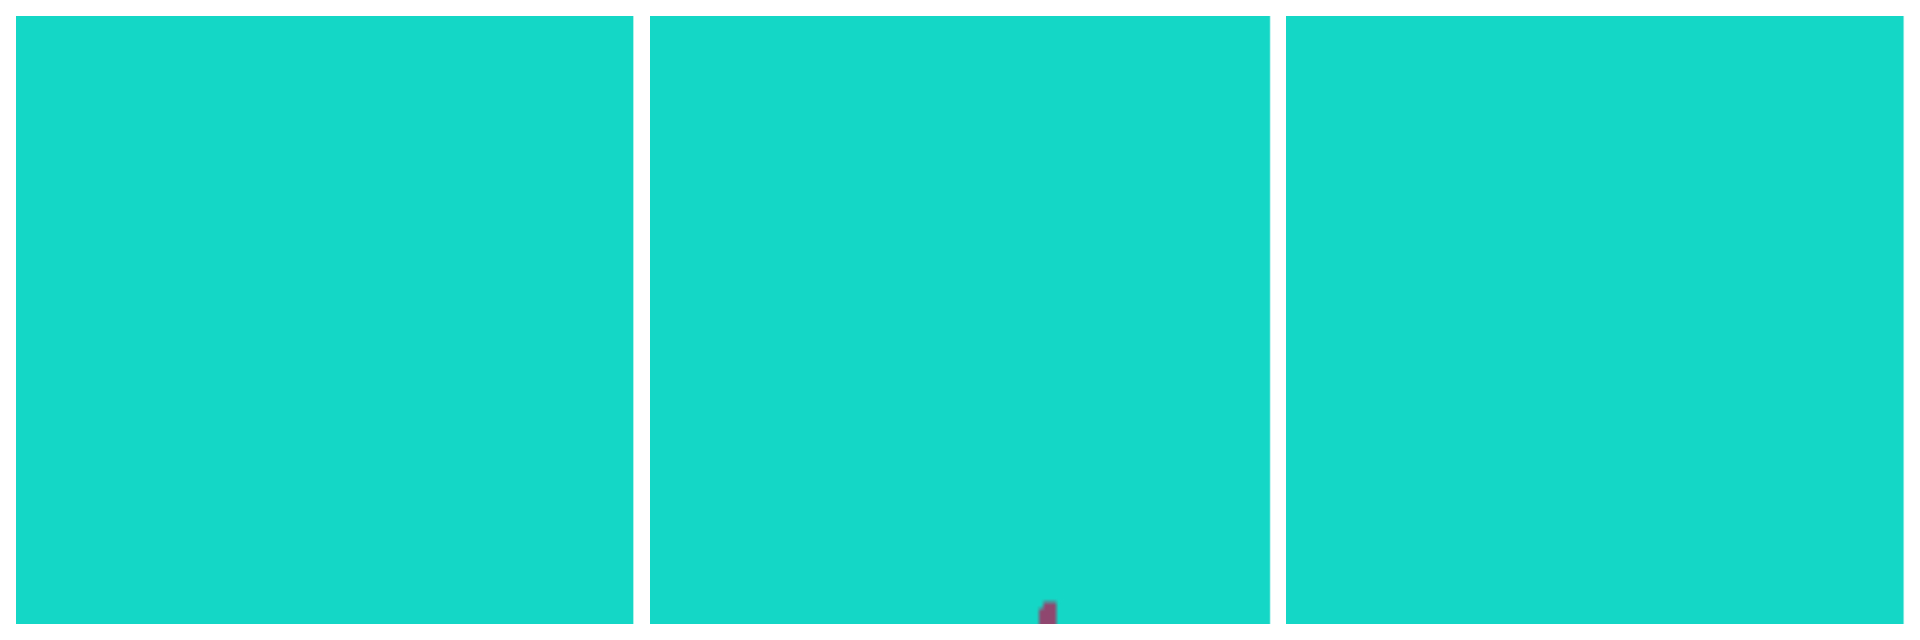

### Model 3
**loss_weights=[0,1e5,1e5,1e5,1e5] and loss function: Focal loss**

In [56]:
import tensorflow_addons as tfa
sfc = tfa.losses.SigmoidFocalCrossEntropy()
model3 = resnet50_pspnet(n_classes=5 ,  input_height=384, input_width=576)
model3.compile(optimizer='adam', loss=sfc,loss_weights=[0,1e5,1e5,1e5,1e5])
model3.train( 
    train_images =  "/kaggle/input/defects-in-solar-panels/train",
    train_annotations = "/kaggle/input/defects-in-solar-panels/train_annots",
    val_images="/kaggle/input/defects-in-solar-panels/valid",
    val_annotations="/kaggle/input/defects-in-solar-panels/valid_annots",
    checkpoints_path = "/kaggle/working/" , epochs=5
)


Verifying training dataset


100%|██████████| 249/249 [00:02<00:00, 113.52it/s]


Dataset verified! 
Epoch 1/5
512/512 [==============================] - 98s 130ms/step - loss: 1.0114 - accuracy: 0.6798
Epoch 2/5
512/512 [==============================] - 67s 130ms/step - loss: 0.2977 - accuracy: 0.9642
Epoch 3/5
512/512 [==============================] - 66s 129ms/step - loss: 0.1931 - accuracy: 0.9683
Epoch 4/5
512/512 [==============================] - 66s 129ms/step - loss: 0.1770 - accuracy: 0.9684
Epoch 5/5
512/512 [==============================] - 66s 129ms/step - loss: 0.1694 - accuracy: 0.9684


In [57]:
out3_0 = model3.predict_segmentation(
    inp="/kaggle/input/defects-in-solar-panels/valid/img2.png",
    out_fname="focalwW-img2-set2.png"
)
out3_1 = model3.predict_segmentation(
    inp="/kaggle/input/defects-in-solar-panels/valid/img13.png",
    out_fname="focalwW-img13-set2.png"
)
out3_2 = model3.predict_segmentation(
    inp="/kaggle/input/defects-in-solar-panels/valid/img7.png",
    out_fname="focalwW-img7-set2.png"
)

1/1 [==============================] - 0s 33ms/step


**Predicted images**
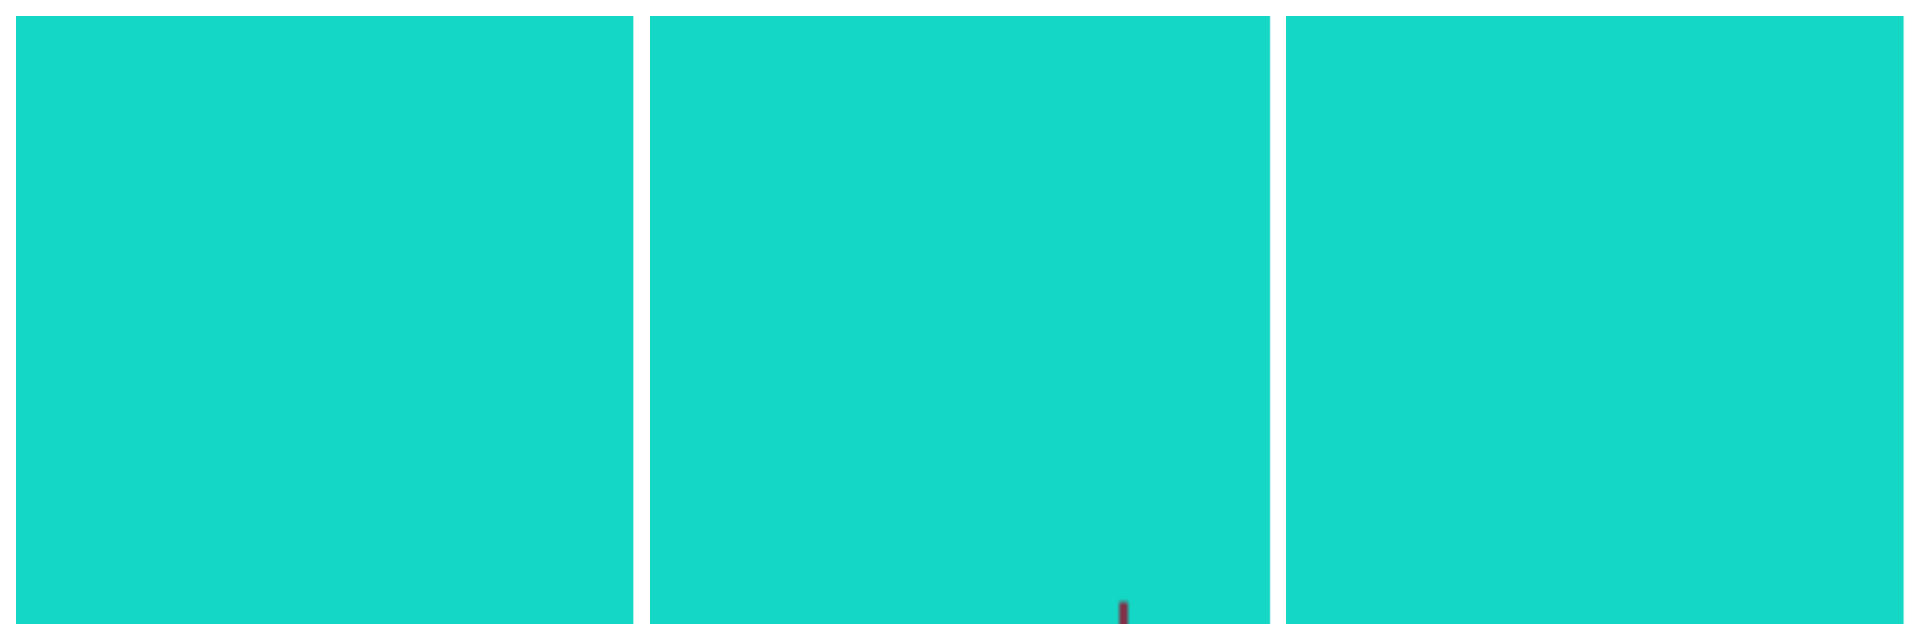

**Inference**

1) Still bad predictions . One possible reason is pretrained on rgb data and is now being transfer learned with greyscale images.

2) Another possible reason is bad dataset. 


**Solutions**

1) we will use the dataset 1 and record observations

### Model 4
**Using  base model: unet architecture with error: wcce [-1e5,1e5,1e5,1e5,1e5]**

**Dataset used: Set2**

In [89]:
from keras_segmentation.models.unet import resnet50_unet
model4= resnet50_unet(n_classes=7,input_height=640, input_width=640) 
model4.compile(optimizer='adam', loss=cce,loss_weights=[-1e5,1e5,1e5,1e5,1e5])
model4.train( 
    train_images =  "/kaggle/input/panelsegset1/train",
    train_annotations = "/kaggle/input/panelsegset1/train_annots",
    val_images="/kaggle/input/panelsegset1/valid",
    val_annotations="/kaggle/input/panelsegset1/valid_annots",
    checkpoints_path = "/kaggle/working/" , epochs=5
)

Verifying training dataset


100%|██████████| 249/249 [00:03<00:00, 65.37it/s]


Dataset verified! 
Epoch 1/5
512/512 [==============================] - 190s 311ms/step - loss: 1.6565 - accuracy: 0.5368
Epoch 2/5
512/512 [==============================] - 160s 313ms/step - loss: 1.3840 - accuracy: 0.6875
Epoch 3/5
512/512 [==============================] - 160s 313ms/step - loss: 1.3048 - accuracy: 0.7197
Epoch 4/5
512/512 [==============================] - 161s 314ms/step - loss: 1.2293 - accuracy: 0.7456
Epoch 5/5
512/512 [==============================] - 160s 313ms/step - loss: 1.1384 - accuracy: 0.7722


In [91]:
out4_0 = model4.predict_segmentation(
    inp="/kaggle/input/panelsegset1/valid/img1.png",
    out_fname="wcce-img1-set1.png"
)
out4_1 = model4.predict_segmentation(
    inp="/kaggle/input/panelsegset1/valid/img2.png",
    out_fname="wcce-img2-set1.png"
)
out4_2 = model4.predict_segmentation(
    inp="/kaggle/input/panelsegset1/valid/img3.png",
    out_fname="wcce-img3-set1.png"
)

1/1 [==============================] - 0s 33ms/step


### For set 1, we are going to validate based on these 3 images
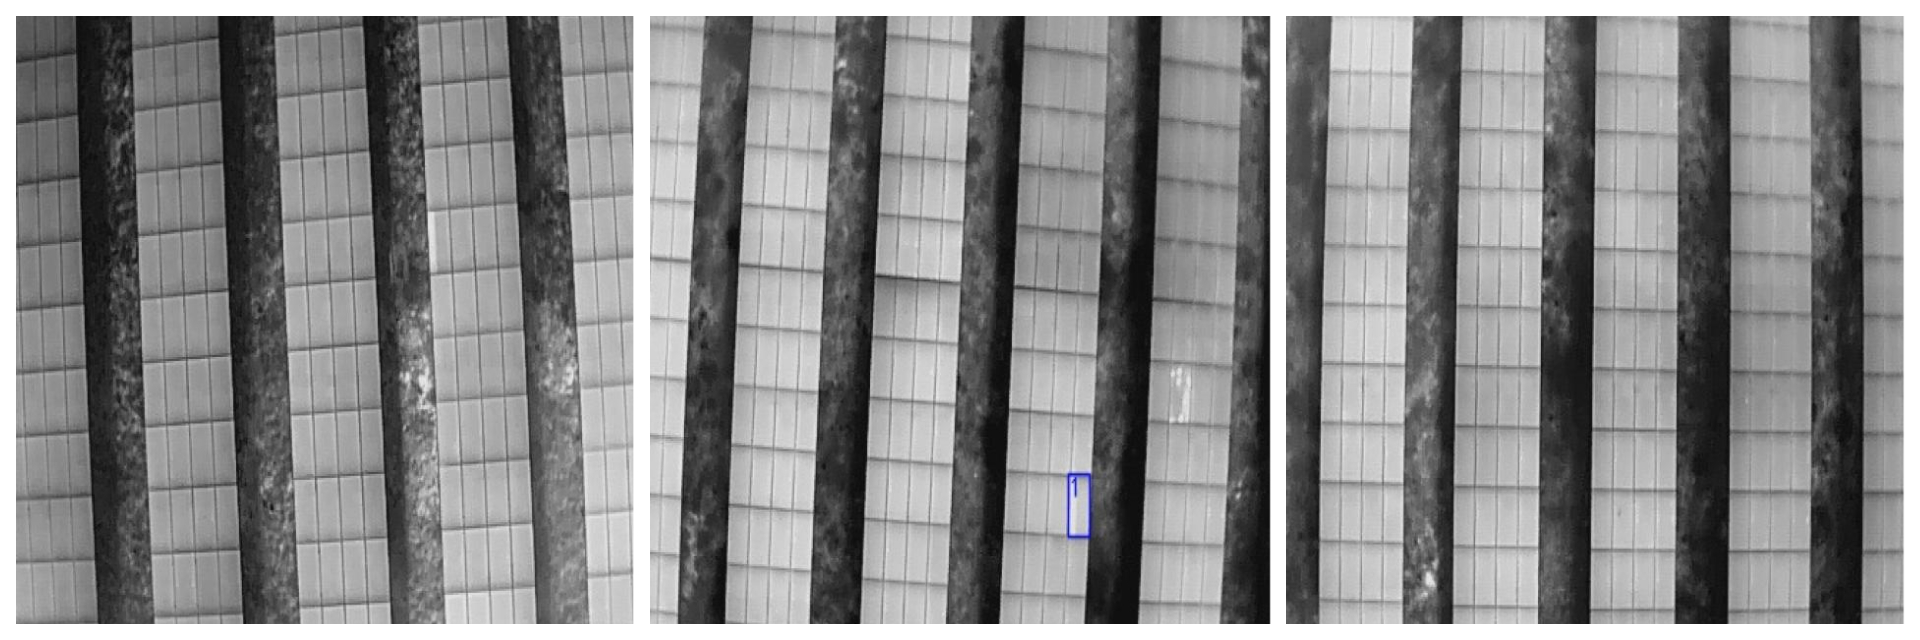

**Predicted images**
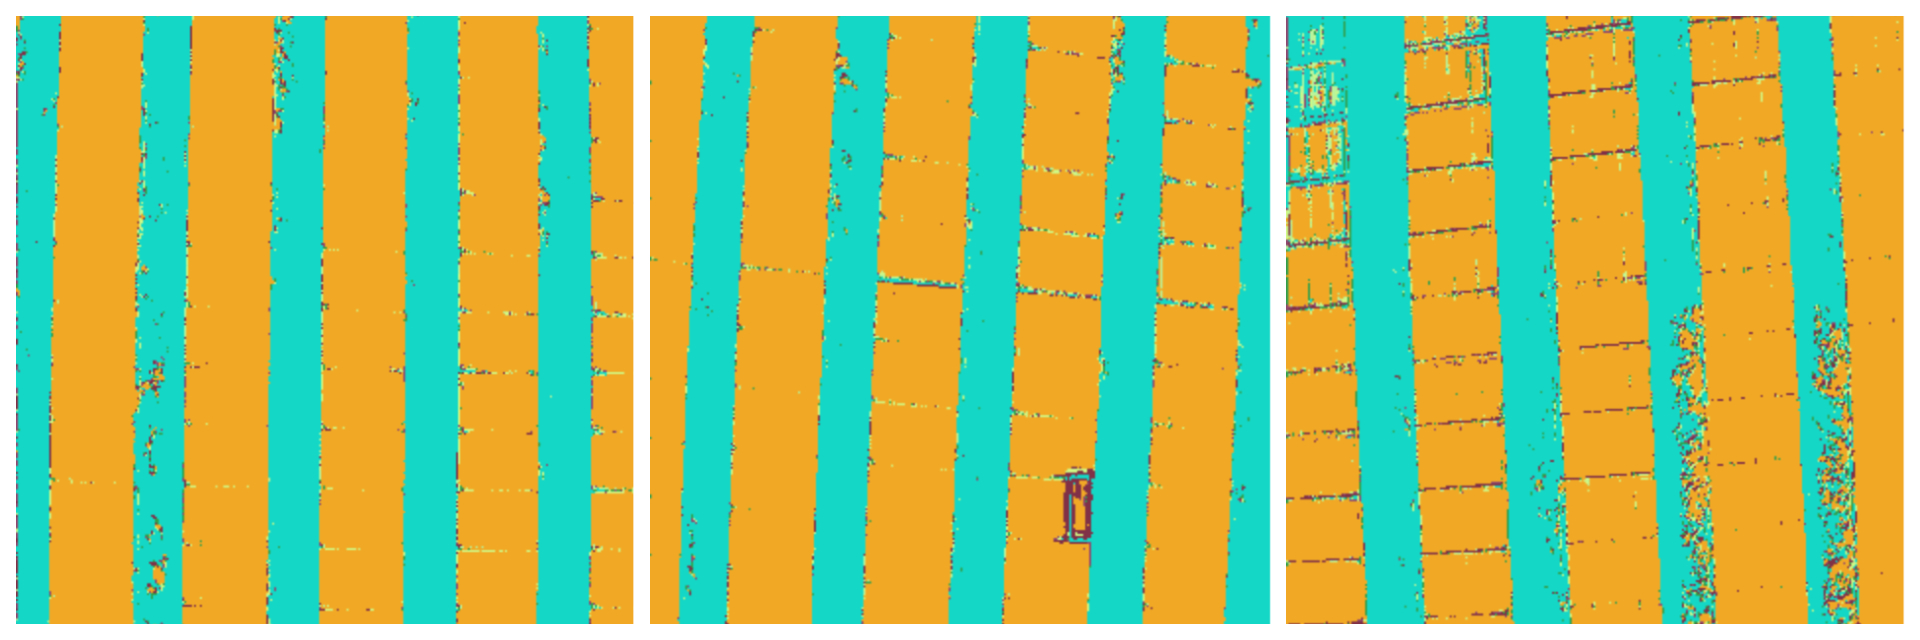

**Inference**
1) Model is able to predict between solar panels and background. but due to most of the panels being in normal, model is unable to distinguish between good and faulty ones.

**Possible solutions**
1) Adjust weights for CCE so that class 4 has very low weight.



**Possible solution**
* Crop images to produce a dataset which has collection of 10-12 solar panels( faulty and good ones) per image
* Train a model on this to produce segmentation.
* Use this model on bigger images

### Model 5
**Same model as before but with different weights for errors.**
- Highest error weight for BP due to its low occurence.
- Followed by DHS , it has moderate occurence.
- Followed by LHS , it has frequent occurence.
- Followed by Normal panel, it has most frequent occurence.

In [18]:
from keras_segmentation.models.unet import resnet50_unet
model5= resnet50_unet(n_classes=5,input_height=640, input_width=640) 
model5.compile(optimizer='adam', loss=cce,loss_weights=[0,1e5,1e4,1e3,0])
model5.train( 
    train_images =  "/kaggle/input/panelsegset1/train",
    train_annotations = "/kaggle/input/panelsegset1/train_annots",
    val_images="/kaggle/input/panelsegset1/valid",
    val_annotations="/kaggle/input/panelsegset1/valid_annots",
    checkpoints_path = "/kaggle/working/" , epochs=5
)

Verifying training dataset


100%|██████████| 249/249 [00:02<00:00, 106.15it/s]


Dataset verified! 
Epoch 1/5
512/512 [==============================] - 186s 307ms/step - loss: 1.3600 - accuracy: 0.6092
Epoch 2/5
512/512 [==============================] - 157s 307ms/step - loss: 1.1893 - accuracy: 0.6903
Epoch 3/5
512/512 [==============================] - 157s 307ms/step - loss: 1.1007 - accuracy: 0.7285
Epoch 4/5
512/512 [==============================] - 157s 307ms/step - loss: 1.0192 - accuracy: 0.7586
Epoch 5/5
512/512 [==============================] - 157s 306ms/step - loss: 0.9215 - accuracy: 0.7888


In [19]:
out5_0 = model5.predict_segmentation(
    inp="/kaggle/input/defects-in-solar-panels-set1/valid/img1.png",
    out_fname="wcce2-img1-set1.png"
)
out5_1 = model5.predict_segmentation(
    inp="/kaggle/input/defects-in-solar-panels-set1/valid/img2.png",
    out_fname="wcce2-img2-set1.png"
)
out5_2 = model5.predict_segmentation(
    inp="/kaggle/input/defects-in-solar-panels-set1/valid/img3.png",
    out_fname="wcce2-img3-set1.png"
)

1/1 [==============================] - 0s 35ms/step


In [20]:
out5_3 = model5.predict_segmentation(
    inp="/kaggle/input/defects-in-solar-panels-set1/valid/img8.png",
    out_fname="wcce2-img8-set1.png"
)

1/1 [==============================] - 0s 35ms/step


**Predicted images**
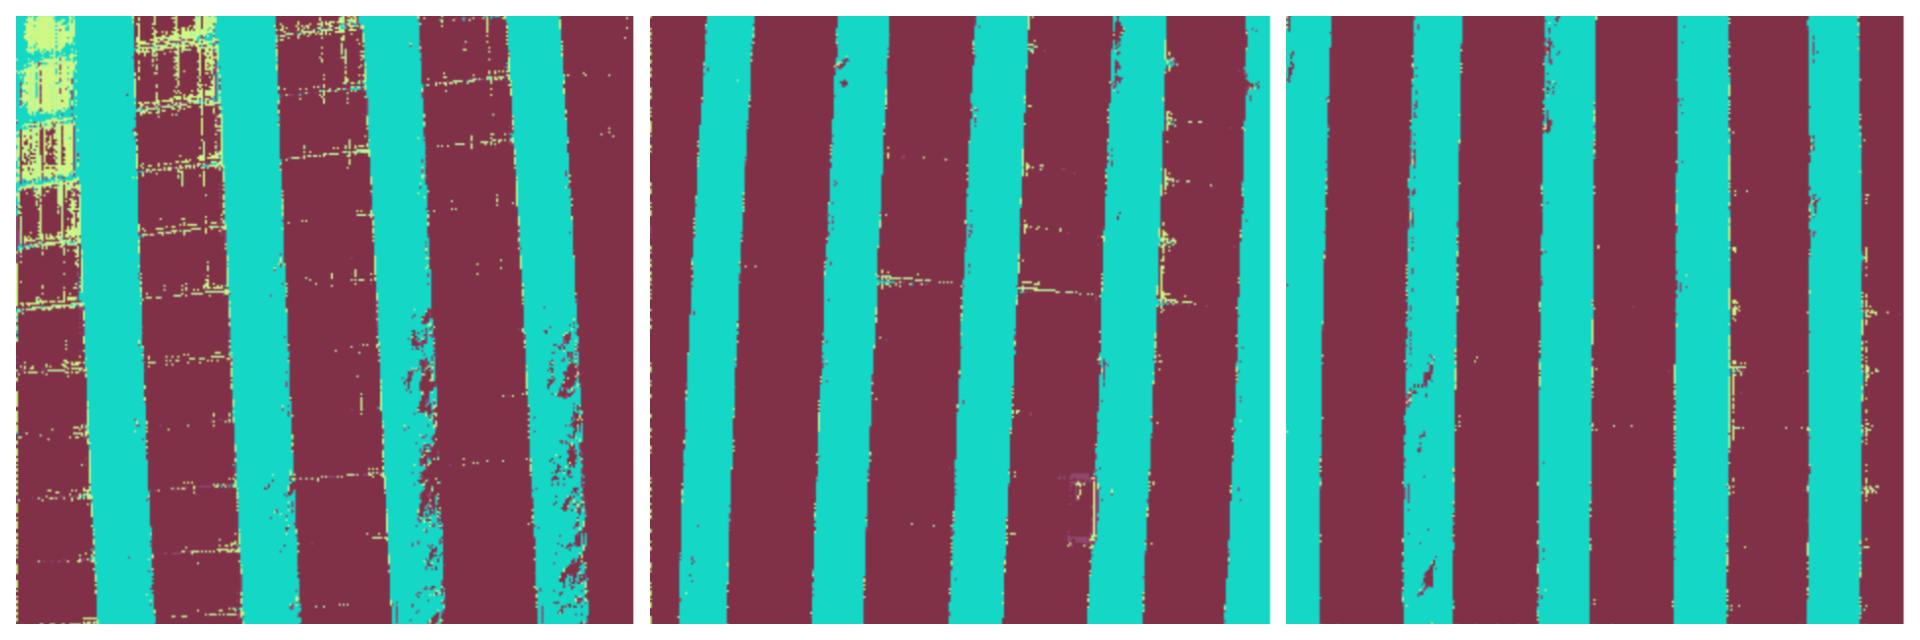

**Inference**

1)It is thus very hard to segment less occuring classes from one single model.


**Solution**


1)Combination of models:
- Create a model which seperates solar panels from ground.
- Create a second model which classifies the solar panels alone into defective and non defective.


### Due to time , resource constraints the development has been halted at this stage.